In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans



In [57]:
ccData = pd.read_csv('CC_General.csv')
print("Rows :", ccData.shape[0])
print("Columns :" ,ccData.shape[1])
ccData.head()

Rows : 8950
Columns : 18


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


#### we don't have a response var, and we can remove the customer id

In [60]:
ccData = ccData.drop("CUST_ID", axis=1)

#### check for null values


In [63]:
ccData.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

#### Before handling the null values, let's understand what `Minimum_Payment = null` could mean:

- The customer did not make a payment that month (missed or skipped it).
- The minimum payment was not recorded (e.g., system error or incomplete data).
- The customer is new and hasn't had to pay yet.

Because these scenarios reflect **different possible reasons** and introduce **uncertainty in interpretation**, I have decided to **drop the rows with missing `Minimum_Payment` values** to maintain data consistency and avoid introducing noise into the clustering process.


In [66]:
ccData_clean = ccData.drop(['MINIMUM_PAYMENTS'], axis=1)

#### Before handling the null values, let's understand what `CREDIT_LIMIT = null` could mean:

- The credit limit was never assigned (e.g., customer applied but was not yet approved).
- The value was not recorded due to a system error or data sync issue.
- The customer is new and their credit profile is incomplete.
- It's a rare case where no credit line was issued (e.g., a debit-based or pre-paid account).

Since there's only **one missing value** in the `CREDIT_LIMIT` column and this feature is critical for clustering, I have decided to **drop the row** to ensure data quality and avoid misrepresenting customer segments.


In [69]:
ccData_clean = ccData_clean.drop(['CREDIT_LIMIT'], axis=1)

In [71]:
ccData_clean.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
PAYMENTS                            0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [73]:
scaler = StandardScaler()
scaled_ccData = scaler.fit_transform(ccData_clean)
norm_ccData = normalize(scaled_ccData)

#### perform the PCA

In [76]:
pca = PCA()
pca.fit(norm_ccData)

PCA()

Text(0, 0.5, 'cumulative explained variance')

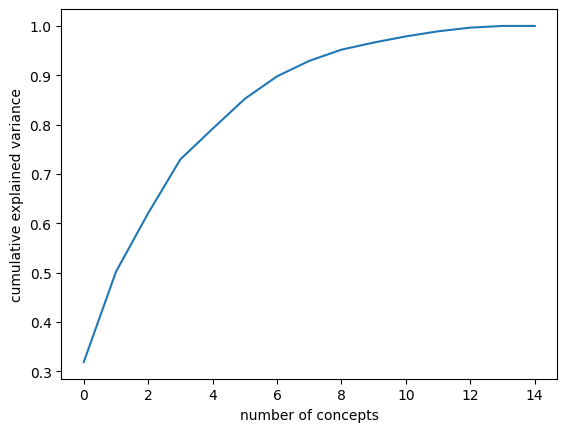

In [78]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of concepts')
plt.ylabel('cumulative explained variance')

In [80]:
np.cumsum(pca.explained_variance_ratio_)

array([0.31929381, 0.50225706, 0.62085643, 0.72979574, 0.79179353,
       0.85240276, 0.89789132, 0.92922482, 0.95193444, 0.96629173,
       0.97882033, 0.9891024 , 0.99652983, 0.99999864, 1.        ])

#### I will use 2 principal components, the first 2 explain 50.2% of the variation in data.

In [83]:
n_components=2
pca_final = PCA(n_components=n_components)
pca_ccData = pca_final.fit_transform(norm_ccData)

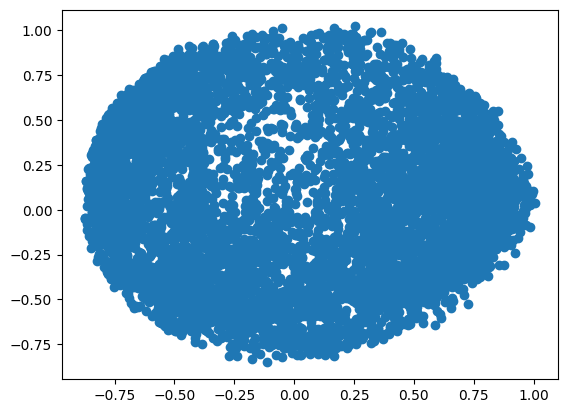

In [85]:
plt.scatter(pca_ccData[:,0], pca_ccData[:,1])

#### when I look at the data there no immediate patterns jumping out at me.Next, I try to interpret these principal components.

In [88]:
for i in np.arange(n_components):
    index = np.argmax(np.absolute(pca_final.get_covariance()[i]))
    max_cov = pca_final.get_covariance()[i][index]
    column = ccData_clean.columns[index]
    print("Principal Components", i+1, "maximum covariance:", "{:.2f}".format(max_cov), "from column", column)
    

Principal Components 1 maximum covariance: 0.07 from column BALANCE
Principal Components 2 maximum covariance: 0.05 from column BALANCE_FREQUENCY


#### Interpreting Principal Components

After applying PCA, we examined which original features contributed most to the new principal components:

- **Principal Component 1 (PC1)** has the highest covariance with the `BALANCE` column (0.07).  
  This means PC1 is primarily driven by the customer's balance amount.
  
- **Principal Component 2 (PC2)** has the highest covariance with the `BALANCE_FREQUENCY` column (0.05).  
  This suggests PC2 captures variation in how frequently customers use their balance.

Together, these two principal components explain **50.2%** of the total variation in the dataset.  
They provide a compressed but meaningful representation of customer behavior, suitable for clustering or visualization.


#### perform k mean clustering on the 2 components PCA transformed data with clusters ranging from 2 to 11 and plot the K Means inertia against the number of clusters.(Elbow Method).From the elbow plot indentify the ideal required number of clusters.

In [92]:
sse = {}
n_clust = np.arange(2,12)

for i in n_clust:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(pca_ccData)
    sse[i] = kmeans.inertia_

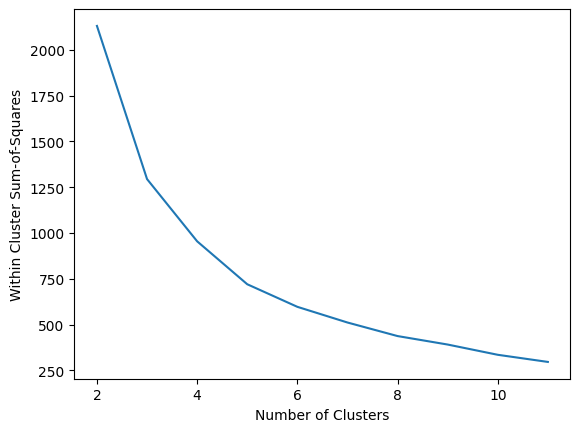

In [94]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Within Cluster Sum-of-Squares")
plt.show()

#### perform K Means Clustering on the 2 component PCA transformed data with ideal number of clusters found in step 6

In [97]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(pca_ccData)

KMeans(n_clusters=4, random_state=0)

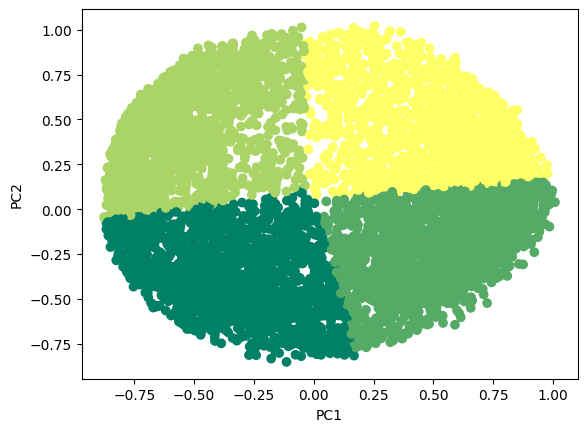

In [101]:
plt.scatter(pca_ccData[:,0], pca_ccData[:,1],
            c = KMeans(n_clusters = 4).fit_predict(pca_ccData),
            cmap = plt.cm.summer)
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()



#### Visualize the Cluster

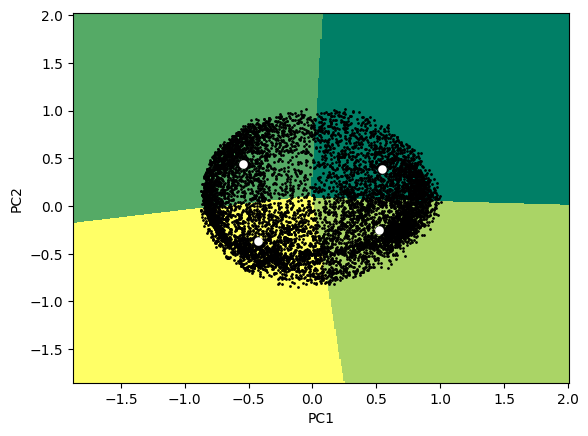

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Step size in the mesh
h = 0.01

# Create a mesh grid over PCA components
x_min, x_max = pca_ccData[:, 0].min() - 1, pca_ccData[:, 0].max() + 1
y_min, y_max = pca_ccData[:, 1].min() - 1, pca_ccData[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

# Predict cluster labels for each point in the grid
Z = kmeans.predict(np.array(list(zip(xx.ravel(), yy.ravel()))))
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(1)
plt.clf()

# Display the decision boundary
plt.imshow(
    Z,
    interpolation='nearest',
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.summer,
    aspect='auto',
    origin='lower'
)

# Plot the actual PCA-reduced data points
plt.plot(pca_ccData[:, 0], pca_ccData[:, 1], 'k.', markersize=2)

# Plot the centroids
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    marker='o',
    s=10,
    linewidths=3,
    color='w',
    zorder=10
)

# Set axis limits and labels
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [106]:
for i in np.arange(len(centroids)):
    print("Center of Cluster", i + 1, ":", centroids[i])



Center of Cluster 1 : [0.54322415 0.38448248]
Center of Cluster 2 : [-0.5439398   0.43673209]
Center of Cluster 3 : [ 0.52051839 -0.24705499]
Center of Cluster 4 : [-0.42283227 -0.36762047]


In [114]:
c = KMeans(n_clusters=4).fit_predict(pca_ccData)
ccData_clean['cluster'] = c
for i in range(4):
    print(f"Cluster {i + 1}")
    print(ccData_clean[ccData_clean['cluster'] == i].mean(numeric_only=True))
    print("\n" + "="*50 + "\n")


Cluster 1
BALANCE                             755.095831
BALANCE_FREQUENCY                     0.750558
PURCHASES                           234.287763
ONEOFF_PURCHASES                    190.882952
INSTALLMENTS_PURCHASES               43.604729
CASH_ADVANCE                        366.273847
PURCHASES_FREQUENCY                   0.144978
ONEOFF_PURCHASES_FREQUENCY            0.076447
PURCHASES_INSTALLMENTS_FREQUENCY      0.064980
CASH_ADVANCE_FREQUENCY                0.067689
CASH_ADVANCE_TRX                      1.136012
PURCHASES_TRX                         2.361592
PAYMENTS                            833.655549
PRC_FULL_PAYMENT                      0.065780
TENURE                               11.534464
cluster                               0.000000
dtype: float64


Cluster 2
BALANCE                             367.124096
BALANCE_FREQUENCY                     0.864184
PURCHASES                           762.680398
ONEOFF_PURCHASES                    256.026045
INSTALLMENTS_PURCHASES 

In [117]:
ccData_clean['BALANCE'].describe()


count     8950.000000
mean      1564.474828
std       2081.531879
min          0.000000
25%        128.281915
50%        873.385231
75%       2054.140036
max      19043.138560
Name: BALANCE, dtype: float64

| Balance Value    | Interpretation      |
| ---------------- | ------------------- |
| `0 – 128`        | Very Low            |
| `128 – 873`      | Low                 |
| `873 – 2054`     | Moderate            |
| `2054 – 10,000+` | High                |
| `10,000+`        | Very High / Outlier |


#### Conclusion: 


###  **Customer Clusters Summary Table**

| Cluster | Color on Chart | PC1-PC2 Coordinates | Behavioral Summary                                 | Suggested Label         |
| ------- | -------------- | ------------------- | -------------------------------------------------- | ----------------------- |
| 1       | Dark Green     | `[0.54, 0.38]`      | Moderate balance, steady payments, good user       | **Disciplined Spender** |
| 2       | Teal Green     | `[-0.54, 0.44]`     | Low balance, high installments, regular payments   | **Installment Planner** |
| 3       | Light Green    | `[0.52, -0.25]`     | High balance, very high cash advances, low payoffs | **Cash-Advance Risk**   |
| 4       | Yellow         | `[-0.42, -0.37]`    | High purchases & payments, loyal frequent user     | **High-Value Customer** |




### 🟩 **Cluster 1 (Light Green)** – **Moderate balance, frequent use**

* **Balance**: \~755 → moderate
* **BALANCE\_FREQUENCY**: 0.75 → **uses balance frequently**
* **PURCHASES**: \~234, mostly **one-off**
* **CASH\_ADVANCE**: \~366 → **uses cash advances moderately**
* **PAYMENTS**: \~833 → pays off some balance
* **Summary**: Customers who regularly use their credit card and make **moderate one-time purchases**, take **moderate cash advances**, and **make timely payments**. Possibly revolving credit users with discipline.

---

### 🟨 **Cluster 2 (Yellow)** – **Active spender, low cash advances**

* **BALANCE**: \~367 → **low**
* **PURCHASES**: \~762 → **high**, with **507 in installments**
* **CASH\_ADVANCE**: \~25 → **almost none**
* **PAYMENTS**: \~875 → **very responsible payer**
* **Summary**: These are **responsible customers** who prefer to make **installment purchases**, don't rely on cash advances, and pay off their cards well.

---

### 🟩  **Cluster 3 (Dark Green)** – **Heavy balance and cash advance users**

* **BALANCE**: \~3346 → **very high**
* **CASH\_ADVANCE**: \~3100 → **extremely high**
* **PURCHASES**: \~261 → low to moderate
* **PRC\_FULL\_PAYMENT**: very low (\~0.03) → **rarely pay full balance**
* **PAYMENTS**: \~2398 → **make large payments but carry large balances**
* **Summary**: Possibly **financially stretched customers**. They rely heavily on cash advances and don't pay their balances in full. Could indicate **riskier profiles**.

---

### 🟩 **Cluster 4 (Teal Green)** – **High spenders and payers**

* **BALANCE**: \~2337 → high
* **PURCHASES**: \~3106 → **very high**
* **INSTALLMENTS\_PURCHASES**: \~1159 → heavy on installments
* **CASH\_ADVANCE**: \~844 → moderate
* **PAYMENTS**: \~3345 → **very high** (close to purchases)
* **Summary**: These are **premium customers** who spend a lot, split purchases into installments, sometimes take cash advances, and **pay most of it off**. Likely **high-value, low-risk customers**.

---

### How to Use This Insight

I can now:

* **Profile each cluster** → marketing, customer support, risk modeling.
* **Build recommendation systems** based on typical behaviors in each group.
* Flag **Cluster 3** for **credit risk management**.
* Treat **Cluster 4** as **VIP customers** for loyalty rewards.

---


